In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

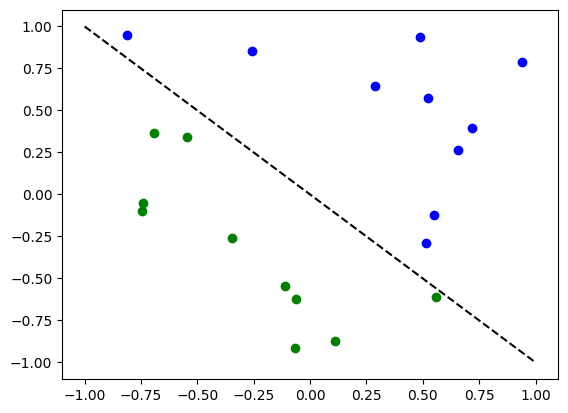

In [2]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

/home/viniods/anaconda3/envs/qcomputing/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


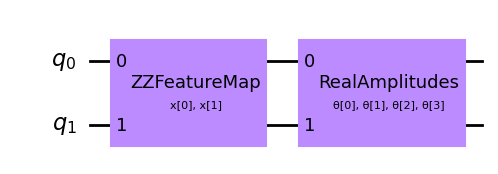

In [3]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw(output="mpl")

In [4]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [5]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [7]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

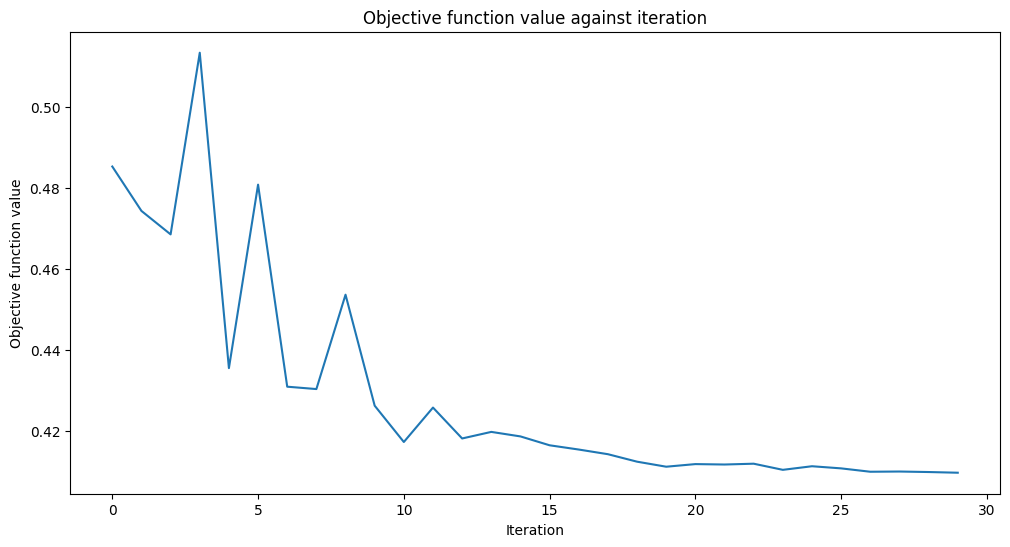

0.8

In [9]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

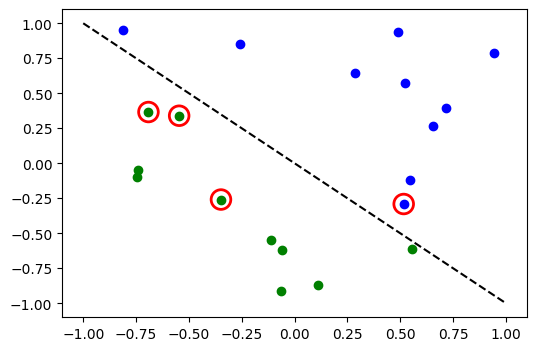

In [10]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [11]:
sampler_classifier.weights


array([1.60763725, 2.88000446, 0.92813038, 1.88775409])